# Data extraction

In [1]:
%matplotlib inline
import re
import sys

import numpy as np
import pandas as pd

import seaborn as sb
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold


with open('data/train.csv', 'r') as f:
    X = pd.read_csv(f)
train_ids = X['PassengerId']

with open('data/test.csv', 'r') as f:
    Xtest = pd.read_csv(f)
test_ids = Xtest['PassengerId']
X.head(3)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Feature Engineering

In [2]:
full_data = [X, Xtest]

for data_set in full_data:
    # Mapping sex
    data_set['Sex'] = data_set['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Remove NULL age
    age_avg = data_set['Age'].mean()
    age_std = data_set['Age'].std()
    age_null_cnt = data_set['Age'].isnull().sum()
    age_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, age_null_cnt)
    data_set.loc[np.isnan(data_set['Age']), 'Age'] = age_random_list
    data_set['Age'] = data_set['Age'].astype(int)

    # Create feature family_size
    data_set['family_size'] = data_set['SibSp'] + data_set['Parch'] + 1
    
    # Create feature is_alone
    data_set['is_alone'] = 0
    data_set.loc[data_set['family_size'] == 1, 'is_alone'] = 1
    
    # Remove NULL embarked
    data_set['Embarked'] = data_set['Embarked'].fillna('S')
    
    # Remove NULL Fare
    data_set['Fare'] = data_set['Fare'].fillna(data_set['Fare'].median())

    # Function to extract title from name
    def get_title(name):
        result = re.search('([A-Za-z]+)\.', name)
        if result:
            return result.group(1)
        return ''
    
    # Create feature title
    data_set['title'] = data_set['Name'].apply(get_title)
    data_set['title'] = data_set['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data_set['title'] = data_set['title'].replace('Mlle', 'Miss')
    data_set['title'] = data_set['title'].replace('Ms', 'Miss')
    data_set['title'] = data_set['title'].replace('Mme', 'Mrs')
    
    # Mapping title
    title_mapping = {'Mr': 1, 'Master': 2, 'Mrs': 3, 'Miss': 4, 'Rare': 5}
    data_set['title'] = data_set['title'].map(title_mapping)
    data_set['title'] = data_set['title'].fillna(0)
    
    # Mapping Embarked
    data_set['Embarked'] = data_set['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Mapping Fare
    data_set.loc[data_set['Fare'] <= 7.91, 'Fare'] = 0
    data_set.loc[(data_set['Fare'] > 7.91) & (data_set['Fare'] <= 14.454), 'Fare'] = 1
    data_set.loc[(data_set['Fare'] > 14.454) & (data_set['Fare'] <= 31), 'Fare'] = 2
    data_set.loc[data_set['Fare'] > 31, 'Fare'] = 3
    data_set['Fare'] = data_set['Fare'].astype(int)
    
    # Mapping Cabin
    data_set['has_cabin'] = data_set['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    
    # Mapping Age
    data_set.loc[data_set['Age'] <= 16, 'Age'] = 0
    data_set.loc[(data_set['Age'] > 16) & (data_set['Age'] <= 32), 'Age'] = 1
    data_set.loc[(data_set['Age'] > 32) & (data_set['Age'] <= 48), 'Age'] = 2
    data_set.loc[(data_set['Age'] > 48) & (data_set['Age'] <= 64), 'Age'] = 3
    data_set.loc[data_set['Age'] > 64, 'Age'] = 4
    
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
X = X.drop(drop_elements, axis=1)
Xtest = Xtest.drop(drop_elements, axis=1)

m, n = X.shape
print(X.shape)
y_train = X['Survived'].ravel()
X_train = X.drop(['Survived'], axis=1)
cols = X_train.columns.values
X_train = X_train.values
X_test = Xtest.values
X.head(3)

(891, 11)


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,family_size,is_alone,title,has_cabin
0,0,3,1,1,0,0,0,2,0,1,0
1,1,1,0,2,0,3,1,2,0,3,1
2,1,3,0,1,0,1,0,1,1,4,0


# Pearson Correlation

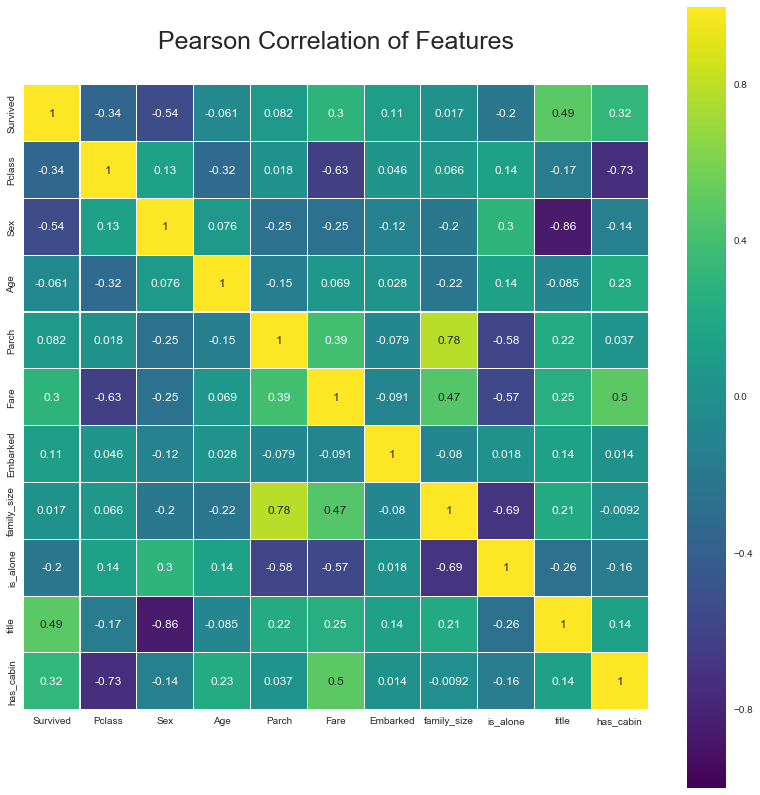

In [3]:
colormap = plt.cm.viridis
plt.figure(figsize=(14, 14))
plt.title('Pearson Correlation of Features', y=1.05, size=25)
sb.heatmap(X.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

# Out-of-Fold Predictions

In [4]:
m_train = X.shape[0]
m_test = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(m_train, n_folds= NFOLDS, random_state=SEED)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((m_train,))
    oof_test = np.zeros((m_test,))
    oof_test_skf = np.empty((NFOLDS, m_test))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generate First-Level classifiers

In [5]:
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        importances = self.clf.fit(x,y).feature_importances_
        print(importances)
        return importances

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

# Train First-Level classifiers

In [6]:
print('Start to training')

et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train, X_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, X_train, y_train, X_test) # Support Vector Classifier

print("Training is complete")

Start to training


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:303: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



Training is complete


# Feature importances from different classifiers

In [7]:
rf_features = rf.feature_importances(X_train,y_train).reshape(10)
et_features = et.feature_importances(X_train, y_train).reshape(10)
ada_features = ada.feature_importances(X_train, y_train).reshape(10)
gb_features = gb.feature_importances(X_train,y_train).reshape(10)

[ 0.13178112  0.23357901  0.04071319  0.02378095  0.08274123  0.02676634
  0.08245464  0.01618978  0.28726983  0.0747239 ]


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:303: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[ 0.13113535  0.34158072  0.0336794   0.01603528  0.06085326  0.0298491
  0.04933989  0.01960816  0.23359886  0.08431997]
[ 0.036  0.172  0.026  0.154  0.02   0.018  0.094  0.002  0.458  0.02 ]
[ 0.11163464  0.03311729  0.10980134  0.06863097  0.19860172  0.13635091
  0.14179763  0.04077489  0.11962415  0.03966645]


In [8]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.036,0.131135,0.111635,0.131781,Pclass
1,0.172,0.341581,0.033117,0.233579,Sex
2,0.026,0.033679,0.109801,0.040713,Age
3,0.154,0.016035,0.068631,0.023781,Parch
4,0.020,0.060853,0.198602,0.082741,Fare
5,0.018,0.029849,0.136351,0.026766,Embarked
6,0.094,0.049340,0.141798,0.082455,family_size
7,0.002,0.019608,0.040775,0.016190,is_alone
8,0.458,0.233599,0.119624,0.287270,title
9,0.020,0.084320,0.039666,0.074724,has_cabin


In [9]:
def plot_scatter(frame, col_name):
    trace = go.Scatter(
        y = frame[col_name].values,
        x = frame['features'].values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 20,
            color = frame[col_name].values,
            colorscale='Portland',
            showscale=True
        ),
        text = frame['features'].values
    )
    data = [trace]
    layout= go.Layout(
        autosize= True,
        title= col_name,
        hovermode= 'closest',
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename=col_name)

plot_names = ['Random Forest feature importances', 'Extra Trees feature importances',
              'AdaBoost feature importances', 'Gradient Boost feature importances']
for col_name in plot_names:
    plot_scatter(feature_dataframe, col_name)

In [10]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

trace = go.Bar(x=feature_dataframe['features'].values,
               y=feature_dataframe['mean'].values,
               width=0.5,
               marker=dict(
                   color = feature_dataframe['mean'].values,
                   colorscale='Portland',
                   showscale=True,
                   reversescale = False),
               opacity=0.6
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [11]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


## Correlation Heatmap of the Second-Level Traing set

In [12]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
        colorscale='Portland',
        showscale=True,
        reversescale = True)
]
py.iplot(data, filename='labelled-heatmap')

In [13]:
X_train_2nd = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
X_test_2nd = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)
X_train_2nd

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

# Generate Second-Level classifier

In [14]:
gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train_2nd, y_train)
predictions = gbm.predict(X_test_2nd)

predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0,

# Save predictions

In [15]:
answer = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions })

answer.to_csv('data/submit.csv', index=False)